In [1]:
import time
import numpy as np
import dxchange
from utils import nor_phase
from ganrec2 import GANphase
import os
from lib import visualize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from ganrec1 import *
import skimage.io as io
import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)



/beegfs/desy/user/hailudaw/anacon/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
energy = 11
z = 7.8880960e-2
pv = 1.04735263e-7
iter_num = 700

import dxchange
fname_data = 'data/gan_phase/data_spider.tif'
kwargs = {'energy': energy, 'z': z, 'pv': pv, 'iter_num': iter_num, 'phase_only': False, 'save_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_model': False}
data = dxchange.read_tiff(fname_data)
nprj, px,  py = data.shape
data = nor_phase(data)
abs_ratio = 0.01

In [3]:

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, MaxPooling2D, UpSampling2D, concatenate, Dense, Conv2D, Conv2DTranspose, \
    Flatten, concatenate, \
        BatchNormalization, Dropout, \
            ReLU,LeakyReLU, Add, Activation
from tensorflow.keras.models import Model, Sequential, load_model

def dense_norm(units, dropout, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Dense(units, 
            #   activation=tf.nn.tanh, 
              use_bias=True, 
              kernel_initializer=initializer))
    result.add(Dropout(dropout))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def conv2d_norm(filters, size, strides, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2D(filters, 
               size, 
               strides=strides, 
               padding='same',
               kernel_initializer=initializer, 
               use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def dconv2d_norm(filters, size, strides, apply_dropout=False):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2DTranspose(filters, 
                        size, 
                        strides=strides,
                        padding='same',
                        kernel_initializer=initializer,
                        use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.25))

    result.add(LeakyReLU())

    return result


def make_generator(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))
    x = Flatten()(inputs)
    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),
    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    last = conv2d_norm(output_num, 3, 1)

    def tanh_on_first_two(x):
        x = Activation('tanh')(x[:, :, :, :2])
        return tf.reshape(x, [1, img_h, img_w, 2])
    
    def relu_on_last(x):
        x = Activation('relu')(x[:, :, :, 2:])
        return tf.reshape(x, [1, img_h, img_w, 1])
    
    def only_layer(x, i):
        return tf.reshape(x[:, :, :, i], [1, img_h, img_w, 1])

    for fc in fc_stack:
        x = fc(x)

    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])
    # Convolutions
    for conv in conv_stack:
        x = conv(x)
        
    for dconv in dconv_stack:
        x = dconv(x)
    x = last(x)
    #the first two outputs apply tanh, the last one apply relu
    if output_num == 2:
        model = Model(inputs=inputs, outputs=x)
    else:
        model = Model(inputs=inputs, outputs=[tanh_on_first_two(x), only_layer(x, 2)])
        # model = Model(inputs=inputs, outputs=tf.concat([tanh_on_first_two(x), relu_on_last(x)], axis=3))
        # model = Model(inputs=inputs, outputs=tf.concat([tf.reshape(tanh_on_first_two(x[:,:,:,0]), [1, img_h, img_w, 1]), tf.reshape(Activation('tanh')(x[:,:,:,1]), [1, img_h, img_w, 1]), tf.reshape(Activation('sigmoid')(x[:,:,:,2]), [1, img_h, img_w, 1])], axis=3))
    return model
       

In [38]:
import tensorflow as tf
from tensorflow_addons.image import median_filter2d

import numpy as np

from models import *
from utils import *

from joblib import Parallel, delayed


# @tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
    total_loss = real_loss + fake_loss
    return total_loss


def l1_loss(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))
def l2_loss(img1, img2):
    return tf.square(tf.reduce_mean(tf.abs(img1-img2)))



# @tf.function
def generator_loss(fake_output, img_output, pred, l1_ratio):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + l1_loss(img_output, pred) * l1_ratio
    return gen_loss

# @tf.function
def filer_loss(fake_output, img_output, img_filter):
    f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                    labels=tf.ones_like(fake_output))) + \
              l1_loss(img_output, img_filter) *10
              # l1_loss(img_output, img_filter) * 10
    return f_loss


def tfnor_tomo(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    img = img - tf.reduce_min(img)
    # img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img


def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

def tfnor_diff(img):
    # img = tf.image.per_image_standardization(img)
    # img = img / tf.reduce_max(img)
    # img = img - tf.reduce_min(img)
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img


def avg_results(recon, loss):
    sort_index = np.argsort(loss)
    recon_tmp = recon[sort_index[:10], :, :, :]
    return np.mean(recon_tmp, axis=0)



def phase_fresnel(phase, absorption, ff, px):
    paddings = tf.constant([[px // 2, px // 2], [px // 2, px // 2]])
    # padding1 = tf.constant([[px // 2, px // 2], [0, 0]])
    # padding2 = tf.constant([[0, 0], [px // 2, px // 2]])
    pvalue = tf.reduce_mean(phase[:100, :])
    # phase = tf.pad(phase, paddings, 'CONSTANT',constant_values=1)
    phase = tf.pad(phase, paddings, 'SYMMETRIC')
    # phase = tf.pad(phase, paddings, 'REFLECT')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    # phase = phase
    # absorption = absorption
    abfs = tf.complex(-absorption, phase)
    abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    # ifp = tfnor_phase(ifp)
    return ifp




def phase_fresnel_2(cosine, sine, absorption, ff, px):
    paddings = tf.constant([[px // 2, px // 2], [px // 2, px // 2]])
    # padding1 = tf.constant([[px // 2, px // 2], [0, 0]])
    # padding2 = tf.constant([[0, 0], [px // 2, px // 2]])
    pvalue = tf.reduce_mean(cosine[:100, :])
    # phase = tf.pad(phase, paddings, 'CONSTANT',constant_values=1)
    cosine = tf.pad(cosine, paddings, 'SYMMETRIC')
    sine = tf.pad(sine, paddings, 'SYMMETRIC')
    # phase = tf.pad(phase, paddings, 'REFLECT')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    # abfs = #amplitude * (cosine - i * sine)
    abfs = tf.complex(tf.exp(-1*absorption) * cosine, tf.exp(-1*absorption)  * sine)
    # abfs = tf.complex(-absorption, phase)
    # abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    # ifp = tfnor_phase(ifp)
    return ifp




def phase_fraunhofer(phase, absorption):
    wf = tf.complex(absorption, phase)
    # wf = tf.complex(phase, absorption)

    # wf = mask_img(wf)
    # wf = tf.multiply(ampl, tf.exp(phshift))
    # wf = tf.manip.roll(wf, [160, 160], [0, 1])
    ifp = tf.square(tf.abs(tf.signal.fft2d(wf)))
 
    
    # # adding log to the fft
    # ifp = tf.math.log(ifp+8000)
    ifp = tf.math.log(ifp+10000)
    # ifp = tf.math.log(tf.abs(tf.signal.fft2d(wf))+1)
    # ifp = tf.math.log(tf.square(tf.abs(tf.signal.fft2d(wf)))+1)
    ifp = tf.signal.fftshift(ifp)
  
    # ifp = tf.roll(ifp, [256, 256], [0, 1])
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tfnor_diff(ifp)
    return ifp


def diffusion_layer(input_tensor, sigma=1.0):
    size = int(sigma*4)
    x = tf.linspace(-3.0, 3.0, size)
    z = (1.0/(sigma*tf.sqrt(2.0*3.1415)))*tf.exp(-tf.square(x)/(2.0*sigma*sigma))
    z_2d = tf.matmul(tf.reshape(z, [size, 1]), tf.reshape(z, [1, size]))
    z_4d = tf.reshape(z_2d, [size, size, 1, 1])
    return tf.nn.depthwise_conv2d(input_tensor, z_4d, [1, 1, 1, 1], 'SAME')



import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, MaxPooling2D, UpSampling2D, concatenate, Dense, Conv2D, Conv2DTranspose, \
    Flatten, concatenate, \
        BatchNormalization, Dropout, \
            ReLU,LeakyReLU, Add, Activation
from tensorflow.keras.models import Model, Sequential, load_model

def dense_norm(units, dropout, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Dense(units, 
            #   activation=tf.nn.tanh, 
              use_bias=True, 
              kernel_initializer=initializer))
    result.add(Dropout(dropout))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def conv2d_norm(filters, size, strides, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2D(filters, 
               size, 
               strides=strides, 
               padding='same',
               kernel_initializer=initializer, 
               use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def dconv2d_norm(filters, size, strides, apply_dropout=False):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2DTranspose(filters, 
                        size, 
                        strides=strides,
                        padding='same',
                        kernel_initializer=initializer,
                        use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.25))

    result.add(LeakyReLU())

    return result

def make_generator(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))
    x = Flatten()(inputs)
    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),
    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]
    last_1 = conv2d_norm(output_num + 1, 3, 1)
    last = conv2d_norm(output_num, 3, 1)

    def tanh_on_first_two(x):
        x = Activation('tanh')(x[:, :, :, :2])
        return tf.reshape(x, [1, img_h, img_w, 2])
    
    def relu_on_last(x):
        x = Activation('relu')(x[:, :, :, 2:])
        return tf.reshape(x, [1, img_h, img_w, 1])
    
    def only_layer(x, i):
        return tf.reshape(x[:, :, :, i], [1, img_h, img_w, 1])

    for fc in fc_stack:
        x = fc(x)

    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])
    # Convolutions
    for conv in conv_stack:
        x = conv(x)
        
    for dconv in dconv_stack:
        x = dconv(x)
    x = last_1(x)
    
    x = [tanh_on_first_two(x), only_layer(x,2)]
    phase = tf.atan2(x[0][0, :, :, 0], x[0][0, :, :, 1])
    phase = tfnor_phase(tf.reshape(phase, [1, img_h, img_w, 1]))
    absorption = tfnor_phase(tf.reshape((x[1][0, :, :, 0]), [1, img_h, img_w, 1]))
    x = tf.concat([phase, absorption], axis=3)

    x = last(x)
    
    #the first two outputs apply tanh, the last one apply relu
    if output_num == 2:
        model = Model(inputs=inputs, outputs=x)
    else:
        # x = [tanh_on_first_two(x), only_layer(x,2)]
        # phase = tf.atan2(x[0][0, :, :, 0], x[0][0, :, :, 1])
        # phase = tfnor_phase(tf.reshape(phase, [1, img_h, img_w, 1]))
        # absorption = tfnor_phase(tf.reshape((x[1][0, :, :, 0]), [1, img_h, img_w, 1]))
        # x = tf.concat([phase, absorption], axis=3)
        model = Model(inputs=inputs, outputs=x)
        # model = Model(inputs=inputs, outputs=[tanh_on_first_two(x), relu_on_last(x)])
        # model = Model(inputs=inputs, outputs=tf.concat([tanh_on_first_two(x), relu_on_last(x)], axis=3))
        # model = Model(inputs=inputs, outputs=tf.concat([tf.reshape(tanh_on_first_two(x[:,:,:,0]), [1, img_h, img_w, 1]), tf.reshape(Activation('tanh')(x[:,:,:,1]), [1, img_h, img_w, 1]), tf.reshape(Activation('sigmoid')(x[:,:,:,2]), [1, img_h, img_w, 1])], axis=3))
    return model
       



class GANphase:
    def __init__(self, i_input, energy, z, pv, **kwargs):
        phase_args = _get_GANphase_kwargs()
        phase_args.update(**kwargs)
        super(GANphase, self).__init__()
        self.i_input = i_input
        self.px, self.py = i_input.shape
        self.energy = energy
        self.z = z
        self.pv = pv
        self.internal_iter = kwargs['internal_iter']
        self.last_retrieval = kwargs['last_retrieval']
        self.iter_num = phase_args['iter_num']
        self.conv_num = phase_args['conv_num']
        self.conv_size = phase_args['conv_size']
        self.dropout = phase_args['dropout']
        self.l1_ratio = phase_args['l1_ratio']
        self.abs_ratio = phase_args['abs_ratio']
        self.g_learning_rate = phase_args['g_learning_rate']
        self.d_learning_rate = phase_args['d_learning_rate']
        self.phase_only = phase_args['phase_only']
        self.save_wpath = phase_args['save_wpath']
        self.init_wpath = phase_args['init_wpath']
        self.init_model = phase_args['init_model']
        self.save_model = phase_args['save_model']
        self.recon_monitor = phase_args['recon_monitor']
        self.filter_type = phase_args['filter_type']
        self.output_num = phase_args['output_num']
        self.filter = None
        self.generator = None
        self.discriminator = None
        self.filter_optimizer = None
        self.generator_optimizer = None
        self.discriminator_optimizer = None

    def make_model(self):
        self.filter = make_filter(self.i_input.shape[0],
                                  self.i_input.shape[1])
        self.generator = make_generator(self.i_input.shape[0],
                                        self.i_input.shape[1],
                                        self.conv_num,
                                        self.conv_size,
                                        self.dropout,
                                        self.output_num)
        self.discriminator = make_discriminator(self.i_input.shape[0],
                                                self.i_input.shape[1])
        self.filter_optimizer = tf.keras.optimizers.Adam(5e-3)
        self.generator_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.d_learning_rate)

    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def rec_step(self, i_input, ff, phase_input = None, absorption_input = None):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.generator(i_input)
        
            #change from list to tensor
            if type(recon) == list:
                print(len(recon), recon[0].shape, recon[1].shape)
                sin_phase = recon[0][0, :, :, 0]
                cos_phase = recon[0][0, :, :, 1]
                
                phase = tf.reshape(tf.atan2(sin_phase, cos_phase), [1, self.px, self.py,1])
                absorption = (1 - tf.reshape(recon[1][0, :, :, 0], [1, self.px, self.py, 1])) * self.abs_ratio
                # sin_phase = tf.reshape(recon[0][0,:,:], [1, self.px, self.py, 1])
                # cos_phase = tf.reshape(recon[1][0,:,:], [1, self.px, self.py, 1])
                
                phase = tfnor_phase(phase)[0, :, :, 0]
                # absorption = (1 - tfnor_phase(absorption)[0, :, :, 0]) * self.abs_ratio 
                
                phase = tf.reshape(phase, [self.px, self.py])
                absorption = tf.reshape((absorption), [self.px, self.py])
                # i_rec = phase_fresnel(phase, absorption, ff, self.px)
                i_rec = phase_fresnel_2(cos_phase, sin_phase, absorption, ff, self.px)
            else:   
                phase = tfnor_phase(recon[:, :, :, 0])
                absorption = tfnor_phase(recon[:, :, :, 1])  
                phase = tf.reshape(phase, [self.px, self.py])
                absorption = tf.reshape((1- absorption) * self.abs_ratio, [self.px, self.py])
            
                if self.phase_only:
                    absorption = tf.zeros_like(phase)
                i_rec = phase_fresnel(phase, absorption, ff, self.px)
            # i_rec = phase_fresnel_2(tf.reshape((recon[:, :, :, 0]), [self.px, self.py]), tf.reshape((recon[:, :, :, 1]), [self.px, self.py]), tf.reshape(tfnor_phase(recon[:, :, :, 2]), [self.px, self.py]), ff, self.px)
        

            real_output = self.discriminator(i_input, training=True)
            fake_output = self.discriminator(i_rec, training=True)
            if phase_input is not None and absorption_input is not None:
                #change their shape
                phase_input = tf.reshape(phase_input, [1, self.px, self.py, 1])
                absorption_input = tf.reshape(absorption_input, [1, self.px, self.py, 1])
                phase = tf.reshape(phase, [1, self.px, self.py, 1])
                absorption = tf.reshape(absorption, [1, self.px, self.py, 1])
                #discremenate between the real phase and the generated phase, and the real absorption and the generated absorption and the real intensity and the generated intensity
                real_output_phase = self.discriminator(phase_input, training=True)
                fake_output_phase = self.discriminator(phase, training=True)
                real_output_abs = self.discriminator(absorption_input, training=True)
                fake_output_abs = self.discriminator(absorption, training=True)
                real_output_i = self.discriminator(i_input, training=True)
                fake_output_i = self.discriminator(i_rec, training=True)
                # fake_output_i_2 = self.discriminator(i_rec_2, training=True)

                g_loss = generator_loss(fake_output_i, i_input, i_rec, self.l1_ratio) + \
                            generator_loss(fake_output_phase, phase_input, phase, self.l1_ratio) + \
                            generator_loss(fake_output_abs, absorption_input, absorption, self.l1_ratio)
                            # generator_loss(fake_output_i_2, i_input, i_rec_2, self.l1_ratio)
                            
                
                d_loss = discriminator_loss(real_output, fake_output) + \
                        discriminator_loss(real_output_phase, fake_output_phase) + \
                            discriminator_loss(real_output_abs, fake_output_abs) + \
                            discriminator_loss(real_output_i, fake_output_i)
                                # discriminator_loss(real_output_i, fake_output_i_2)
                    
                
            else:
                g_loss = generator_loss(fake_output, i_input, i_rec, self.l1_ratio)
                d_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(g_loss,
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                        self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))
        


        return {'phase':  tf.reshape(phase, [self.px, self.py]),
                'absorption': tf.reshape(absorption, [self.px, self.py]),
                'i_rec': i_rec,
                'g_loss': g_loss,
                'd_loss': d_loss,
                'recon': recon}


    def multi_propagation(self, i_input, ffs, retrieved_phase = None, retrieved_absorption = None, filter_type = None):
        if retrieved_phase is not None and retrieved_absorption is not None:
            if filter_type is None:
                filter_type = self.filter_type

            if filter_type == 'median':
                # filter the phase and absorption
                filtered_phase = median_filter2d( tf.reshape(retrieved_phase, [1, self.px, self.py, 1]))[0, :, :, 0]
                filtered_absorption = median_filter2d( tf.reshape(retrieved_absorption, [1, self.px, self.py, 1]))[0, :, :, 0]
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if filter_type == 'contrast':
                # add contrast to the phase and absorption
                filtered_phase = (retrieved_phase - tf.reduce_min(retrieved_phase))/ (tf.reduce_max(retrieved_phase) - tf.reduce_min(retrieved_phase))
                filtered_absorption = (retrieved_absorption - tf.reduce_min(retrieved_absorption))/ (tf.reduce_max(retrieved_absorption) - tf.reduce_min(retrieved_absorption))
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            
            if filter_type == 'noise':
                # add noise to the phase and absorption
                filtered_phase = retrieved_phase + tf.random.normal(retrieved_phase.shape, mean=0.0, stddev=0.1, dtype=tf.float32)
                filtered_absorption = retrieved_absorption + tf.random.normal(retrieved_absorption.shape, mean=0.0, stddev=0.1, dtype=tf.float32)
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if filter_type == 'diffuse':
                # diffuse
                # ffs = [ffs[0]]*5
                sigma_coeff = list(np.arange(0.9, 1.1, 0.2))
                ffs = [ffs[0]]*len(sigma_coeff)
                filtered_phases = [diffusion_layer(tf.reshape(retrieved_phase, [1, self.px, self.py, 1]), sigma=sigma_coeff[i])[0, :, :, 0] for i in range(len(sigma_coeff))]
                filtered_absorptions = [diffusion_layer(tf.reshape(retrieved_absorption, [1, self.px, self.py, 1]), sigma=sigma_coeff[i])[0, :, :, 0] for i in range(len(sigma_coeff))]
                step_results = [self.rec_step(phase_fresnel(filtered_phases[i], filtered_absorptions[i], ffs[0], self.px), ffs[0], phase_input = filtered_phases[i], absorption_input = filtered_absorptions[i]) for i in range(len(sigma_coeff))]
            if filter_type == 'phase_only':
                # diffuse
                sigma_coeff = list(np.arange(0.5, 0.5*len(ffs), 0.5))
                filtered_phases = [diffusion_layer(tf.reshape(retrieved_phase, [1, self.px, self.py, 1]), sigma=sigma_coeff[i])[0, :, :, 0] for i in range(len(sigma_coeff))]
                filtered_absorption = np.zeros_like(filtered_phases[0])
                step_results = [self.rec_step(phase_fresnel(filtered_phases[i], filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phases[i], absorption_input = filtered_absorption) for i in range(len(sigma_coeff))]
            if filter_type == 'alternate':
                factors = np.arange(1, 1000, 100)
                step_results = []
                for factor in factors:
                    filtered_phase =  median_filter2d( tf.reshape(retrieved_phase * factor, [1, self.px, self.py, 1]))[0, :, :, 0]
                    filtered_absorption = median_filter2d( tf.reshape(retrieved_absorption / factor, [1, self.px, self.py, 1]))[0, :, :, 0]
                    step_result = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
                    step_results.append(step_result) 
                    
        else:
            step_results = self.rec_step(i_input, ffs[0])
        return step_results
    
    @property
    def recon(self):
        ff = ffactor(self.px * 2, self.py *2, self.energy, self.z, self.pv)
        ffs = []
        
        ffs.append(ff)
        for i in range(1, self.internal_iter):
            z_i = self.z * (1 + 1/i)
            ffs.append(ffactor(self.px * 2, self.py *2, self.energy, z_i, self.pv))
        for i in range(1, self.internal_iter):
            z_i = self.z / (1 + 1/i)
            ffs.append(ffactor(self.px * 2, self.py *2, self.energy, z_i, self.pv))
        ffs.append(ff)
        # print(ff.shape, ff.max(), ff.min())

        i_input = np.reshape(self.i_input, (1, self.px, self.py, 1))
        i_input = tf.cast(i_input, dtype=tf.float32)
        self.make_model()

        if self.init_model:
            self.generator.load_weights(self.init_wpath+'generator.h5')
            print('generator is initilized')
            self.discriminator.load_weights(self.init_wpath+'discriminator.h5')
            print('discriminator is initilized')

        phase = np.zeros((self.iter_num, self.px, self.py))
        absorption = np.zeros((self.iter_num, self.px, self.py))
        gen_loss = np.zeros(self.iter_num)
        i_rec_all = np.zeros((self.iter_num, self.px, self.py))

        ###########################################################################
        # Reconstruction process monitor
        
        plot_x, plot_loss = [], []
        if self.recon_monitor:
            recon_monitor = RECONmonitor('phase')
            recon_monitor.initial_plot(self.i_input)

        side_propagation = []
        ###########################################################################
        for epoch in range(self.iter_num):

            ###########################################################################
            ## Call the rconstruction step
            
            step_results = self.rec_step(i_input, ffs[0])
            side_propagation.append(step_results['recon'])
            print('epoch: {}, g_loss: {}, d_loss: {}'.format(epoch, step_results['g_loss'], step_results['d_loss']))

            if self.last_retrieval:
                if epoch % 100 == 0:
                    retrieved_phase = step_results['phase']
                    retrieved_absorption = step_results['absorption']
                    step_result_i = self.multi_propagation(i_input, ffs, retrieved_phase, retrieved_absorption, filter_type = self.filter_type)
                    # step_result_i = self.rec_step(median_filter2d(i_input), ff)    
                
            phase[epoch, :, :] = step_results['phase']
            absorption[epoch, :, :] = step_results['absorption']
            i_rec = step_results['i_rec']
            i_rec_all[epoch, :, :] = np.reshape(i_rec, (self.px, self.py))
            gen_loss[epoch] = step_results['g_loss']
            d_loss = step_results['d_loss']
            ###########################################################################
                
            plot_x.append(epoch)
            plot_loss = gen_loss[:epoch + 1]

            if (epoch + 1) % 41 == 0:
                # checkpoint.save(file_prefix=checkpoint_prefix)
                if self.recon_monitor:  
                    i_rec = np.reshape(i_rec, (self.px, self.py))
                    i_diff = np.abs(i_rec - self.i_input.reshape((self.px, self.py)))
                    phase_plt = np.reshape(phase[epoch], (self.px, self.py))
                    recon_monitor.update_plot(epoch, i_diff, phase_plt, plot_x, plot_loss)
        if self.recon_monitor:
            recon_monitor.close_plot()

        if self.save_model:
            self.generator.save(self.save_wpath+'generator.h5')
            self.discriminator.save(self.save_wpath+'discriminator.h5')

        return absorption[epoch], phase[epoch], i_rec_all[epoch], gen_loss[epoch], side_propagation



def train(data, energy, z, pv, abs_ratio, iter_num,  idx, phase_only = False, recon_monitor = True, **kwargs):
    import time
    import os
    import dxchange
    if type(data) is not list:
        px = data.shape[0]
        py = data.shape[1]
        kwargs['px'] = px
        kwargs['py'] = py
        gan_phase_object = GANphase(data, energy, z, pv, 
                                    abs_ratio = abs_ratio, 
                                    iter_num = iter_num,
                                    phase_only=phase_only,
                                    recon_monitor = True, **kwargs)
        start = time.time()
        absorption, phase, i_rec_all, gen_loss = gan_phase_object.recon
        end = time.time()
        print('Running time is {}'.format(end - start))
        os.makedirs('data/gan_phase/spider_abs_ratio/abs', exist_ok=True)
        os.makedirs('data/gan_phase/spider_abs_ratio/phase', exist_ok=True)
        os.makedirs('data/gan_phase/spider_abs_ratio/prop_intensity', exist_ok=True)

        dxchange.write_tiff(absorption.reshape((px, py)),
                            'data/gan_phase/spider_abs_ratio/abs/absorption'"-%03d" % (idx),
                            overwrite=True, dtype = np.float32)
        dxchange.write_tiff(phase.reshape((px, py)),
                            'data/gan_phase/spider_abs_ratio/phase/phase'"-%03d" % (idx),
                            overwrite=True, dtype = np.float32)
        dxchange.write_tiff(i_rec_all.reshape((px, py)),
                            'data/gan_phase/spider_abs_ratio/prop_intensity/prop_intensity'"-%03d" % (idx),
                            overwrite=True, dtype = np.float32)
        return absorption, phase, i_rec_all, gen_loss
    else:
        train(abs_ratio, iter_num, phase_only, recon_monitor, **kwargs)

def _get_GANphase_kwargs():
    return{
        'iter_num': 1000,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 0.05,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': True,
        'save_model': False,
        'recon_monitor': False,
        'output_num': 2,
    }

epoch: 0, g_loss: 10.613923072814941, d_loss: 1.3865433931350708
epoch: 1, g_loss: 10.515634536743164, d_loss: 1.4407212734222412
epoch: 2, g_loss: 11.029248237609863, d_loss: 1.0518910884857178
epoch: 3, g_loss: 10.965248107910156, d_loss: 1.1428155899047852
epoch: 4, g_loss: 11.770345687866211, d_loss: 0.9146010875701904
epoch: 5, g_loss: 10.366650581359863, d_loss: 1.6675288677215576
epoch: 6, g_loss: 9.977839469909668, d_loss: 2.8576183319091797
epoch: 7, g_loss: 9.843331336975098, d_loss: 3.501880407333374
epoch: 8, g_loss: 9.70118522644043, d_loss: 3.9116172790527344
epoch: 9, g_loss: 9.49919605255127, d_loss: 3.9821009635925293
epoch: 10, g_loss: 9.216744422912598, d_loss: 3.9292352199554443
epoch: 11, g_loss: 8.795886993408203, d_loss: 4.003152847290039
epoch: 12, g_loss: 8.139589309692383, d_loss: 3.4940919876098633
epoch: 13, g_loss: 7.357816219329834, d_loss: 2.3325977325439453
epoch: 14, g_loss: 6.608016490936279, d_loss: 1.8795812129974365
epoch: 15, g_loss: 5.923132419586

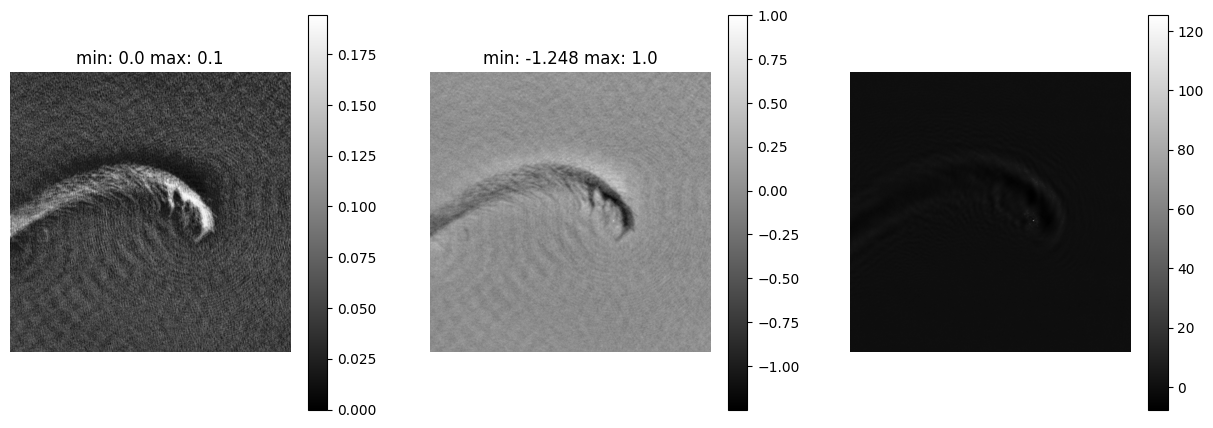

                                                                 0
experiment_name                                spider_hair_149_1.0
iter                                                          1550
sum of pointwise difference                               3.611987
sum of absolute value of pointwise difference            51.642273
sum of squared difference                                68.526009
PSNR                                                    [8.734145]
SSIM                                                  [0.74140376]
NRMSE                                                     8.278044
MSSIM                                                  [0.9438287]
epoch_time                                             [106.67398]
total_time                                              106.673981


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.2686,0.2687,0.2688,0.2689,0.2690,0.2691,0.2692,0.2693,0.2694,0
experiment_name,spider_hair_0_0.005,spider_hair_0_0.001,spider_hair_0_0.01,spider_hair_0_0.1,spider_hair_0_0.005,spider_hair_1_0.005,spider_hair_2_0.005,spider_hair_3_0.005,spider_hair_4_0.005,spider_hair_5_0.005,...,spider_hair_149_0.01,spider_hair_149_0.01,spider_hair_149_0.01,spider_hair_149_1.0,spider_hair_149_1.0,spider_hair_149_1.0,spider_hair_149_1.0,spider_hair_149_1.0,spider_hair_149_1.0,spider_hair_149_1.0
iter,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,350,150,150,150,150,150,150,150,550,1550
sum of pointwise difference,1.0678117,1.0677754,1.0677476,1.0681081,1.0675116,1.7406926,5.294111,4.6951256,-2.0370803,-0.76821685,...,NaN,3.6120882,3.6128428,3.611619,3.6108537,3.6120884,3.61218,3.6123338,3.6120586,3.611987
sum of absolute value of pointwise difference,27.055195,26.410727,19.84621,17.291338,17.791815,33.992867,31.49842,31.038956,31.634548,33.0773,...,NaN,254.5397,194.99054,212.73944,184.41165,239.71277,118.9866,116.41785,87.43572,51.642273
sum of squared difference,5.6280355,5.884934,3.3873558,2.4756074,2.4831715,9.0479965,7.518339,7.4791965,8.405365,9.745775,...,NaN,854.11127,209.40189,336.08893,250.94312,823.99274,132.14124,195.6864,71.14281,68.526009
PSNR,[19.58913],[19.395283],[21.794092],[23.155882],[23.142632],[17.527176],[18.331478],[18.354149],[17.847134],[17.204535],...,[nan],[-2.2224448],[3.8828936],[1.8281574],[3.0969467],[-2.0665343],[5.8823156],[4.177093],[8.571389],[8.734145]
SSIM,[0.89393246],[0.842487],[0.93475425],[0.9483144],[0.93816346],[0.735249],[0.80681175],[0.85031],[0.8700472],[0.8572213],...,[nan],[0.01504825],[0.15409401],[0.09671436],[0.1474021],[0.05347439],[0.34372315],[0.34532693],[0.5089914],[0.74140376]
NRMSE,2.372348,2.4258883,1.840477,1.5734063,1.5758082,3.0079887,2.7419589,2.734812,2.8992007,3.1218224,...,NaN,29.225182,14.470725,18.332727,15.841184,28.705273,11.49527,13.988795,8.434619,8.278044
MSSIM,[0.98695135],[0.9543729],[0.9928939],[0.9946718],[0.99315494],[0.8924219],[0.9378776],[0.97340477],[0.97980803],[0.97619706],...,[nan],[0.12447648],[0.4516836],[0.3319323],[0.4352368],[0.23746614],[0.716954],[0.7105437],[0.82625663],[0.9438287]
epoch_time,[77.765144],[61.675625],[57.26491],[61.144947],[80.770164],[80.770164],[80.770164],[80.770164],[80.770164],[80.770164],...,[23.725975],[11.8637495],[12.358881],[11.498652],[12.009911],[13.48015],[15.325104],[13.956957],[39.46214],[106.67398]


In [42]:
abs_ratio_all = np.arange(0.01, 10*0.04, 0.004)
abs_ratio_all = 1*np.ones(1)

absorption = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
phase = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
propagated = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
loss = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)
time_count = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)

from ganrec_dataloader import measure_reconstruction_quality, tf_reshape, tfback_phase
kwargs['iter_num'] = 1550
kwargs['internal_iter'] = 1
kwargs['last_retrieval'] = False
kwargs['save_wpath'] = 'data/gan_phase/spider_abs_ratio/'
kwargs['init_wpath'] = 'data/gan_phase/spider_abs_ratio/'
kwargs['init_model'] = False
kwargs['save_model'] = False
kwargs['filter_type'] = 'diffuse' #chose from median, contrast, noise, diffuse, phase_only, alternate
kwargs['output_num'] = 3
side_propagations = []


for i, abs_ratio in enumerate(abs_ratio_all):
    idx = i + 149
    gan_phase_object = GANphase(data[idx], **kwargs)
    start = time.time()
    absorption[i], phase[i],propagated[i], loss[i], side_propagation  = gan_phase_object.recon
    side_propagations.append(side_propagation)
    end = time.time()
    time_count[i] = end - start
    matched = tfback_phase( propagated[i], data[idx])
    visualize([absorption[i], phase[i], propagated[i]])#, matched, data[idx], idx, abs_ratio, kwargs['iter_num'])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/phase/phase_'+str(idx)+'_'+str(abs_ratio)+'.tif', phase[i])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/propagated/propagated_'+str(idx)+'_'+str(abs_ratio)+'.tif', propagated[i])
    df = measure_reconstruction_quality(img1=tf_reshape(propagated[i]), img2 = tf_reshape(data[idx]), experiment_name = 'spider_hair_'+str(idx)+'_'+str(abs_ratio), csv_file = 'Vojtech_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count[0], total_time = np.sum(time_count))
    display(df)

In [43]:
# visualize([side_propagations[0][0][0,:,:,0].numpy()])

#using pandas, analyze the mean, std, min, max of the side propagation
import pandas as pd
analysis = pd.DataFrame({'experiment', 'iteration', 'mean_phase', 'std_phase', 'min_phasee', 'max_phase', 'mean_abs', 'std_abs', 'min_abs', 'max_abs'})
for i in range(len(side_propagations)):
    for iter in range(len(side_propagations[0])):
        #fill the values in the dataframe
        new_pd = pd.DataFrame(columns=['experiment', 'iteration', 'mean_phase', 'std_phase', 'min_phase', 'max_phase', 'mean_abs', 'std_abs', 'min_abs', 'max_abs'])
        new_pd['experiment'] = [i]
        new_pd['iteration'] = [iter]
        new_pd['mean_phase'] = [np.mean(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['std_phase'] = [np.std(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['min_phase'] = [np.min(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['max_phase'] = [np.max(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['mean_abs'] = [np.mean(side_propagations[i][iter][0,:,:,1].numpy())]
        new_pd['std_abs'] = [np.std(side_propagations[i][iter][0,:,:,1].numpy())]
        new_pd['min_abs'] = [np.min(side_propagations[i][iter][0,:,:,1].numpy())]
        new_pd['max_abs'] = [np.max(side_propagations[i][iter][0,:,:,1].numpy())]
        analysis = pd.concat([analysis, new_pd], axis=0)
analysis.to_csv('data/gan_phase/spider_abs_ratio/analysis.csv')
analysis


,0,experiment,iteration,mean_phase,std_phase,min_phase,max_phase,mean_abs,std_abs,min_abs,max_abs
0,max_phase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,experiment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,std_abs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,min_abs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,iteration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,0.0,1545.0,-0.008144,0.006375,-0.074809,0.044667,0.104039,0.016090,-0.019429,0.146902
0,NaN,0.0,1546.0,-0.008122,0.006419,-0.074275,0.045781,0.104016,0.016212,-0.018927,0.147455
0,NaN,0.0,1547.0,-0.008148,0.006351,-0.074266,0.045168,0.104020,0.016085,-0.019043,0.146941
0,NaN,0.0,1548.0,-0.008120,0.006457,-0.074922,0.045893,0.104024,0.016204,-0.019103,0.147660


In [99]:
# visualize([side_propagations[0][50][0,:,:,0].numpy(), side_propagations[0][250][0,:,:,0].numpy(), side_propagations[0][400][0,:,:,0].numpy(), side_propagations[0][490][0,:,:,0].numpy()])
# visualize([side_propagations[0][50][0,:,:,1].numpy(), side_propagations[0][250][0,:,:,1].numpy(), side_propagations[0][400][0,:,:,1].numpy(), side_propagations[0][490][0,:,:,1].numpy()])
# visualize([side_propagations[0][50][0,:,:,2].numpy(), side_propagations[0][250][0,:,:,2].numpy(), side_propagations[0][400][0,:,:,2].numpy(), side_propagations[0][490][0,:,:,2].numpy()])

In [118]:
# side_propagations[0][50:55][0].shape

TensorShape([1, 512, 512, 3])

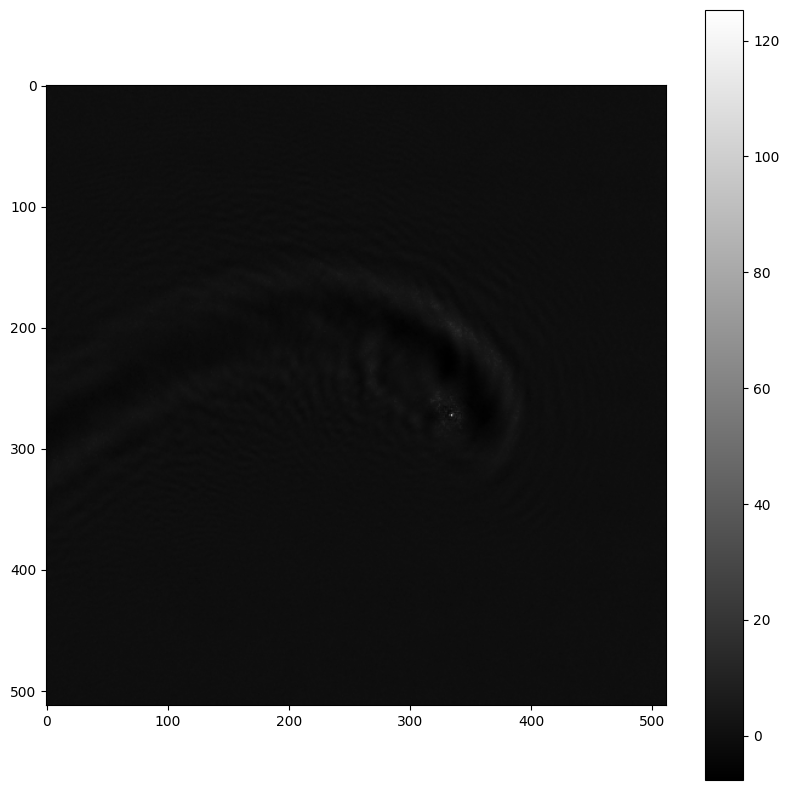

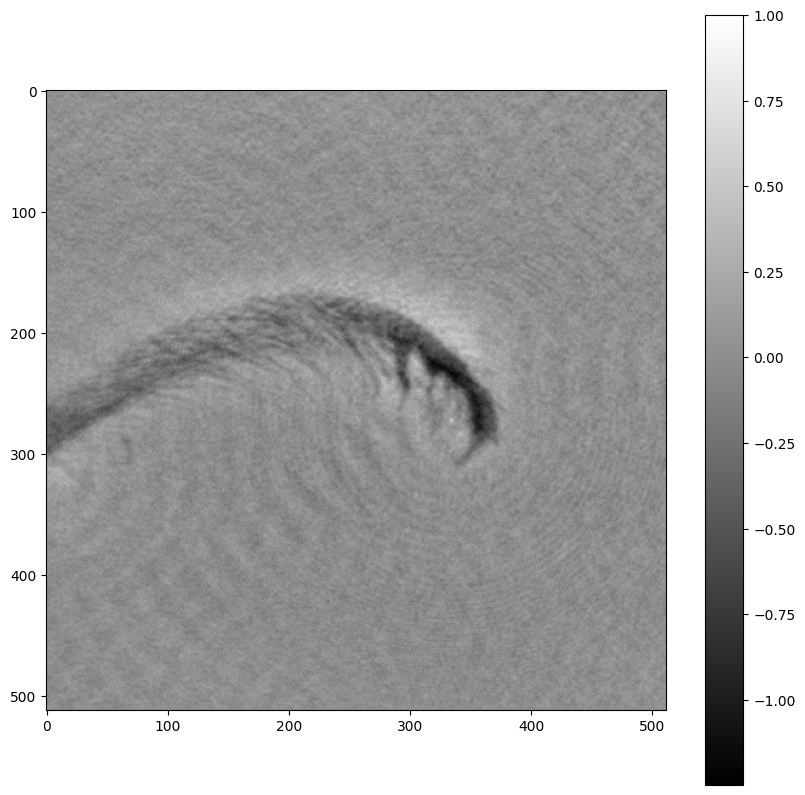

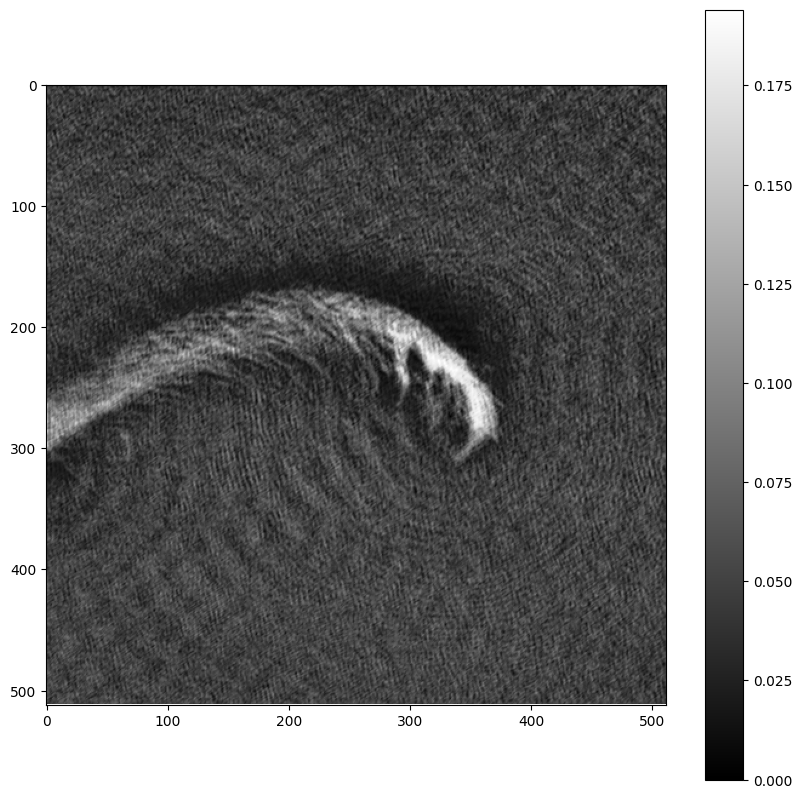

In [44]:
visualize(propagated)
visualize(phase)
visualize(absorption)